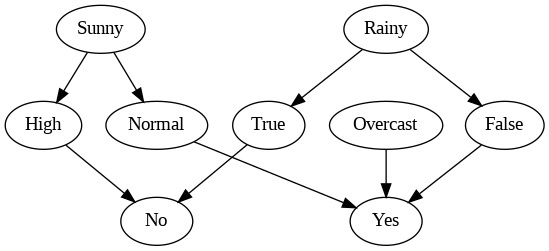

In [ ]:
# If running in Google Colab, you may need to install Graphviz first:
# !apt-get install -qq graphviz

import pandas as pd
import math
from graphviz import Digraph
from IPython.display import Image, display

# Define the dataset
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rainy', 'Rainy', 'Rainy', 'Overcast',
                'Sunny', 'Sunny', 'Rainy', 'Sunny', 'Overcast', 'Overcast', 'Rainy'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool',
                    'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal',
                 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Windy': ['False', 'True', 'False', 'False', 'False', 'True', 'True',
              'False', 'False', 'False', 'True', 'True', 'False', 'True'],
    'Play': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes',
             'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}
df = pd.DataFrame(data)

# Function to calculate entropy of a target column
def entropy(target_col):
    entropy_val = 0
    counts = target_col.value_counts()
    for count in counts:
        prob = count / len(target_col)
        entropy_val -= prob * math.log2(prob)
    return entropy_val

# Function to calculate information gain for a given split attribute
def info_gain(data, split_attribute, target_name="Play"):
    total_entropy = entropy(data[target_name])
    weighted_entropy = 0
    counts = data[split_attribute].value_counts()
    for value, count in counts.items():
        subset = data[data[split_attribute] == value][target_name]
        weighted_entropy += (count / len(data)) * entropy(subset)
    return total_entropy - weighted_entropy

# Recursive function to build the decision tree using the ID3 algorithm
def id3(data, original_data, features, target_attribute="Play", parent_node_class=None):
    # If all target values are the same, return that value (pure node)
    if len(data[target_attribute].unique()) == 1:
        return data[target_attribute].unique()[0]

    # If the dataset is empty, return the most common target value from the original dataset
    if data.empty:
        return original_data[target_attribute].value_counts().idxmax()

    # If no more features remain, return the parent node's class
    if not features:
        return parent_node_class

    # Determine the most common target value in the current dataset for potential backtracking
    parent_node_class = data[target_attribute].value_counts().idxmax()

    # Calculate the information gain for each feature and choose the best one
    info_gains = {feature: info_gain(data, feature, target_attribute) for feature in features}
    best_feature = max(info_gains, key=info_gains.get)

    tree = {best_feature: {}}
    remaining_features = [f for f in features if f != best_feature]

    # Build the subtree for each value of the best feature
    for value in data[best_feature].unique():
        subset = data[data[best_feature] == value]
        subtree = id3(subset, original_data, remaining_features, target_attribute, parent_node_class)
        tree[best_feature][value] = subtree

    return tree

# Build the decision tree
features = list(df.columns[:-1])
decision_tree = id3(df, df, features)

# Function to add nodes and edges to the Graphviz Digraph object
def add_edges(graph, tree, parent=None):
    if isinstance(tree, dict):
        for attribute, branches in tree.items():
            for value, subtree in branches.items():
                # Use an underscore instead of a colon to avoid Graphviz port warnings
                node_id = f"{attribute}_{value}"
                graph.node(node_id, label=value)
                if parent is not None:
                    graph.edge(parent, node_id)
                add_edges(graph, subtree, node_id)
    else:
        leaf_node = f"Leaf_{tree}"
        graph.node(leaf_node, label=tree)
        if parent is not None:
            graph.edge(parent, leaf_node)

# Create and render the decision tree graph
dot = Digraph(format='png')
add_edges(dot, decision_tree)

# Render the graph to a file named "decision_tree.png"
dot.render("decision_tree", cleanup=True)

# Display the resulting image inline in Google Colab
display(Image("decision_tree.png"))
